In [96]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import time

0.8062484252960443
Peloton power 131.3081085200427 Watts
0.07875
0.002
Lurking power 44.67 %
10.624014139175415


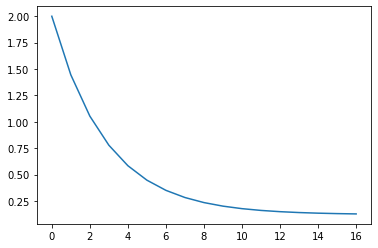

In [117]:
# Drag parameters
C_d_max = 40/0.36/1.225*2/15**2 #from paper
print(C_d_max)
C_d_min = 0.06*C_d_max #from paper
lambda_ = 0.35 # from paper
C_d_avg = 0.5*C_d_max

#Potassium parameters
a = 5
K_max = .1

T_a = .4

d_rider = 4
m_rider = 70
rho = 1.225
Area = 0.36
L = 1e4# 181000
v_hat_peloton = 41/3600*1000
P_p = v_hat_peloton**3*C_d_avg/2*rho*Area
print(f'Peloton power {P_p} Watts')

T = 4*3600+25*60

def C(eta):
    return (C_d_min + (C_d_max-C_d_min)*np.exp(-lambda_*L/d_rider*max(0,eta)))/C_d_avg

C = np.vectorize(C)
plt.plot(np.arange(0,17), C(d_rider/L*np.arange(0,17)))

epsilon = 2*m_rider/(rho*Area*C_d_avg*L)
print(epsilon)
position_0 = 5
eta_hat_0 = d_rider*position_0
eta_0 = eta_hat_0/L
P_0 = C(eta_0)
print(eta_0)
print(f'Lurking power {round(P_0*100,2)} %')
P_b = 2

t_array = np.linspace(0, 1, 500000); dt = t_array[1] - t_array[0]


#crash parameters
omega = .1; N=100
def desired_power(t):
    if t < T_a:
        return P_0
    else:
        return P_b

def x_peloton(t):
    return t
## my own iterations
x_b = np.zeros_like(t_array);v_b = np.zeros_like(t_array); K_concentration = np.zeros_like(t_array)
achievable_power = np.zeros_like(t_array); eta = np.zeros_like(t_array)
start_time = time.time()
v_b[0] = 1; eta[0] = eta_0; x_b[0] = - eta_0; achievable_power[0] = desired_power(0)
for j,t in enumerate(t_array[:-1]):
    eta[j] = x_peloton(t) - x_b[j]
    if K_concentration[j] < K_max:
        achievable_power[j+1] = desired_power(t)
    else:
        achievable_power[j+1] = desired_power(t)*np.exp(-a*(K_concentration[j]-K_max))
    
    dx_dotdt = 1/epsilon * (achievable_power[j+1]/v_b[j] - C(eta[j])*v_b[j]**2)
    v_b[j+1] = v_b[j] + dt * dx_dotdt
    x_b[j+1] = x_b[j] + dt * v_b[j+1]
    
    K_concentration[j+1] = K_concentration[j] + dt * max((achievable_power[j+1] - 1),0)
    eta[j+1] = x_peloton(t+dt) - x_b[j+1]
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

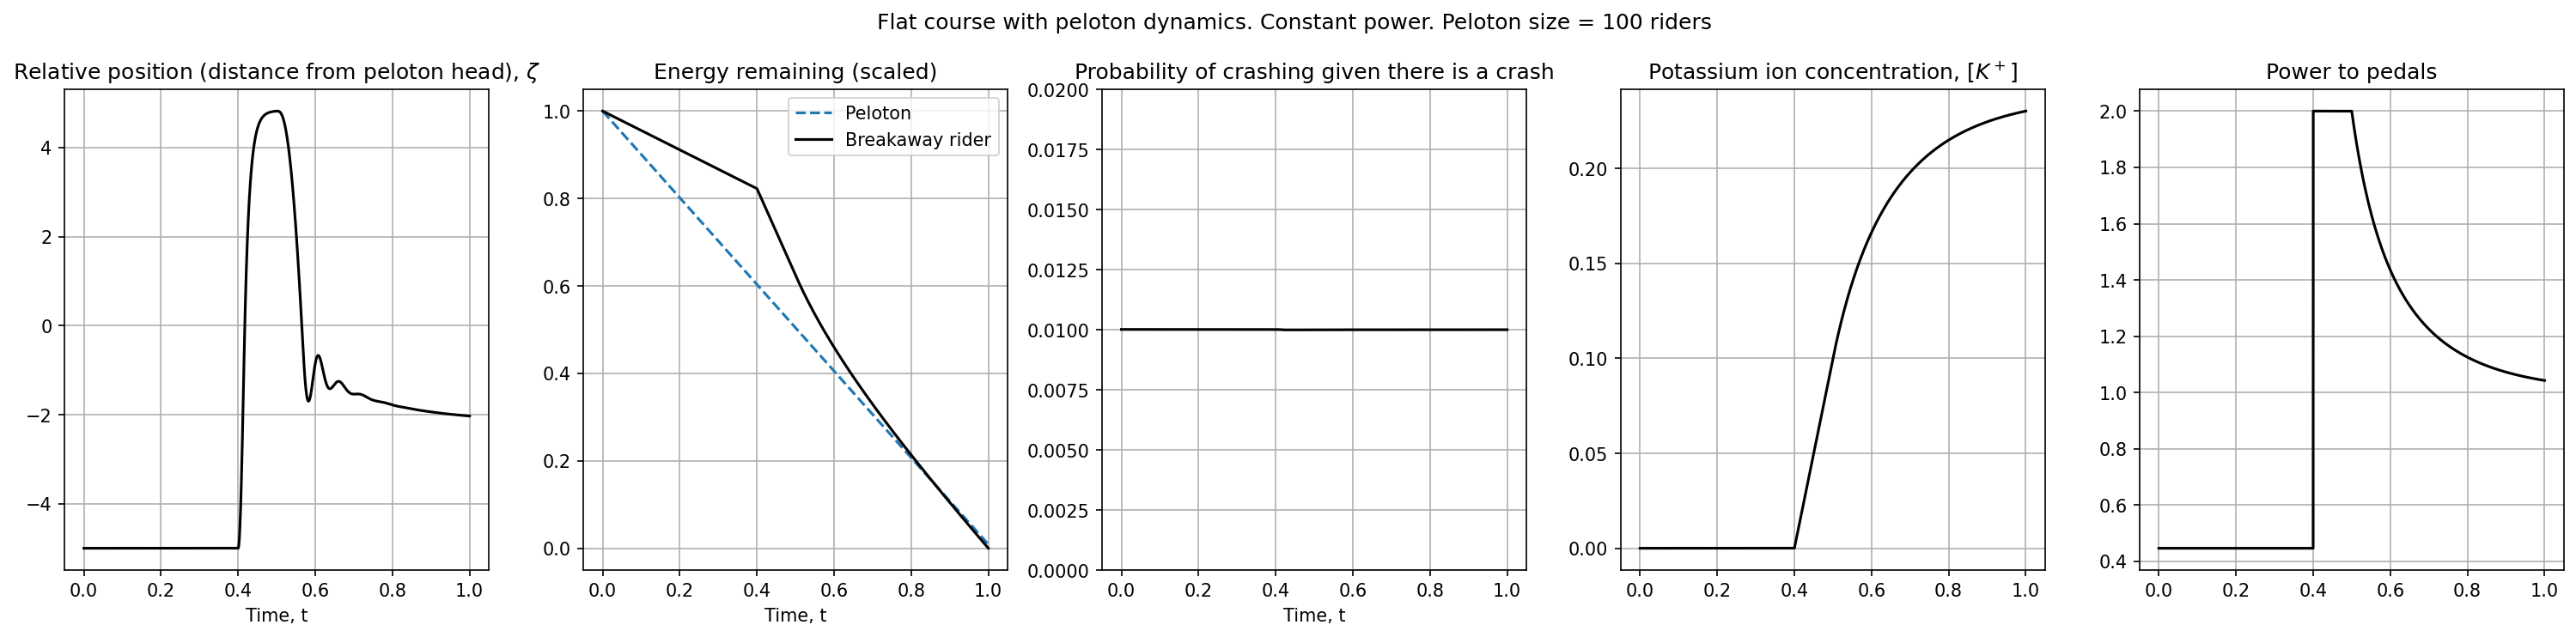

In [116]:
## energy budget
E_peloton = np.cumsum(np.ones_like(t_array)*dt)
E_individual_rider = np.cumsum(achievable_power*dt)
Enery_scale = max(max(E_individual_rider), max(E_peloton))
fig,ax=plt.subplots(nrows=1, ncols =5, figsize = (20,5),dpi =150)
ax[1].plot(t_array,1-E_peloton/Enery_scale,'--', label='Peloton')
ax[1].plot(t_array, 1-E_individual_rider/Enery_scale, label='Breakaway rider', color='black')
ax[1].set_title('Energy remaining (scaled)');ax[1].legend();ax[1].grid()
ax[0].plot(t_array, -eta*L/d_rider,color='black');ax[0].set_title(r'Relative position (distance from peloton head), $\zeta$');ax[0].grid()

prob_crash_unfiltered = np.exp(omega)/N/(1-np.exp(omega))*(-1+np.exp(-omega*(eta+1)))
ax[2].plot(t_array,np.where(eta > 0, prob_crash_unfiltered, 1/N),color='black')
ax[2].set_title('Probability of crashing given there is a crash');ax[2].set_ylim([0,max(prob_crash_unfiltered)+0.01]);ax[2].grid()
ax[3].plot(t_array, K_concentration,color='black');ax[3].set_title(r'Potassium ion concentration, $[K^+]$');ax[3].grid()
ax[4].plot(t_array, achievable_power,color='black'); ax[4].set_title('Power to pedals');ax[4].grid()
ax[0].set_xlabel('Time, t');ax[1].set_xlabel('Time, t');ax[2].set_xlabel('Time, t')
plt.suptitle('Flat course with peloton dynamics. Constant power. Peloton size = 100 riders')
plt.tight_layout()
#plt.savefig('flat_course_power_first_results.jpg')

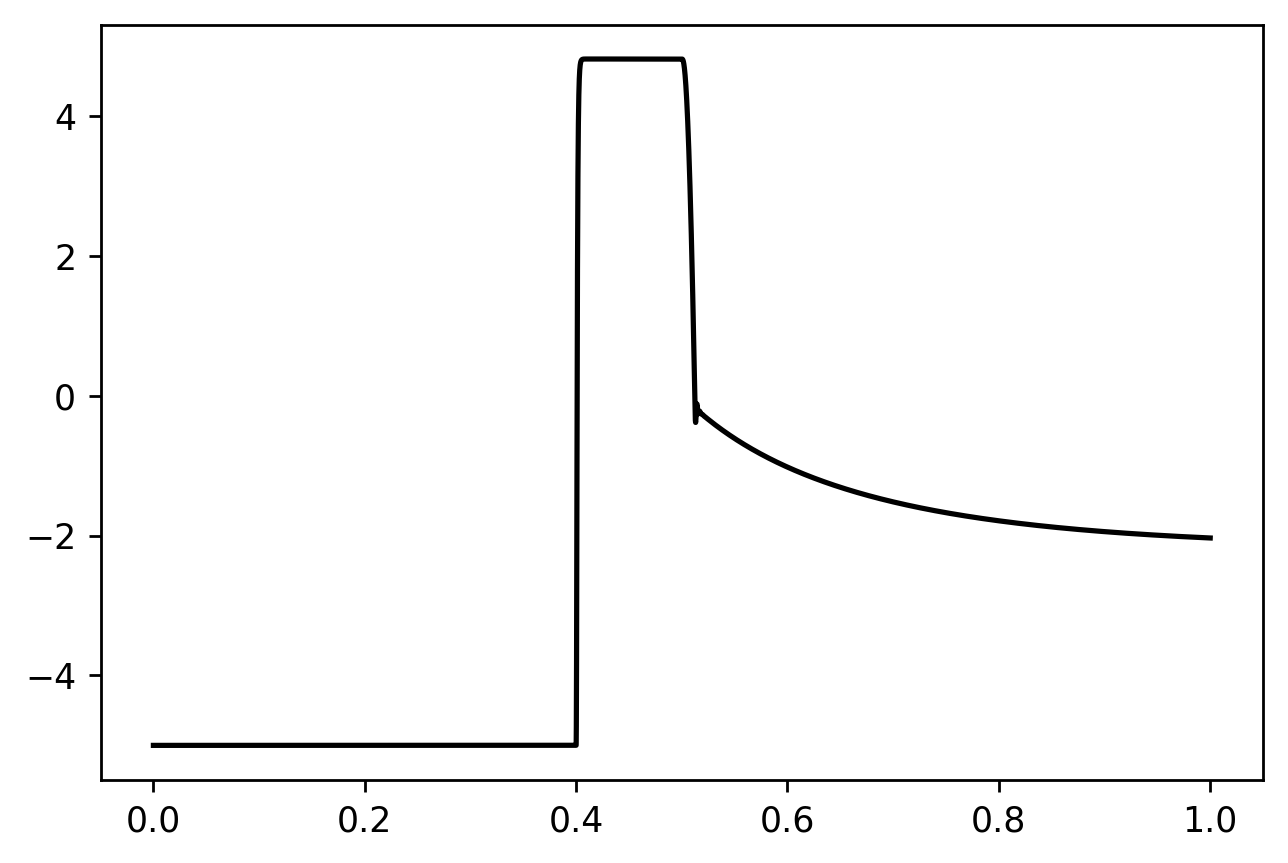

In [114]:
plt.figure(dpi=250)
plt.plot(t_array, -eta*L/d_rider,color='black')

In [148]:
## my own iterations
x_b = np.zeros_like(t_array);v_b = np.zeros_like(t_array); K_concentration = np.zeros_like(t_array)
achievable_power = np.zeros_like(t_array); eta = np.zeros_like(t_array)

v_b[0] = v_peloton; eta[0]= eta_0; x_b[0]=-eta_0; achievable_power[0]=desired_power(0)
for j,t in enumerate(t_array[:-1]):
    eta[j] = x_peloton(t) - x_b[j]
    if K_concentration[j] < K_max:
        achievable_power[j+1] = desired_power(t)
    else:
        achievable_power[j+1] = desired_power(t)*np.exp(-(K_concentration[j]-K_max))
    
    dx_dotdt = 1/m_b*(achievable_power[j+1]/v_b[j] - C_d(eta[j])*v_b[j]**2)
    v_b[j+1] = v_b[j] + dt*dx_dotdt
    x_b[j+1] = x_b[j] + dt*v_b[j+1]
    
    K_concentration[j+1] = K_concentration[j] + dt * max((achievable_power[j+1]-P_0),0)
    eta[j+1] = x_peloton(t+dt) - x_b[j+1]
    

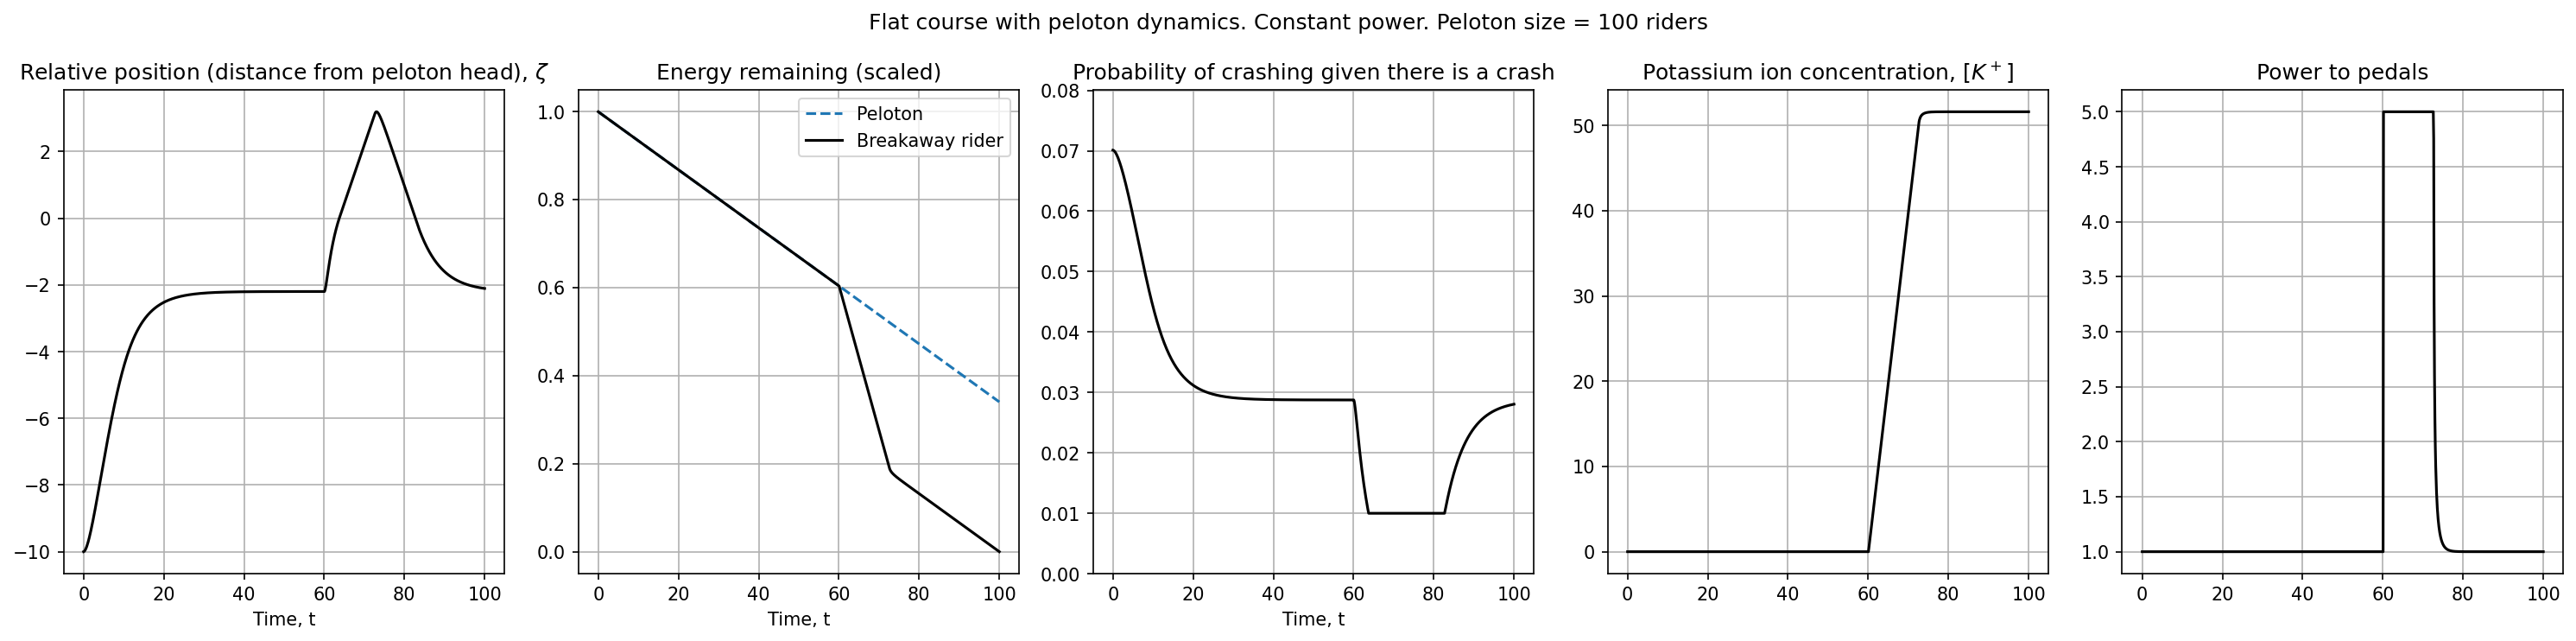

In [149]:
## energy budget
E_peloton = np.cumsum(P_0*np.ones_like(t_array)*dt)
E_individual_rider = np.cumsum(achievable_power*dt)
Enery_scale = max(E_individual_rider)
fig,ax=plt.subplots(nrows=1, ncols =5, figsize = (20,5),dpi =150)
ax[1].plot(t_array,1-E_peloton/Enery_scale,'--', label='Peloton')
ax[1].plot(t_array, 1-E_individual_rider/Enery_scale, label='Breakaway rider',color='black')
ax[1].set_title('Energy remaining (scaled)');ax[1].legend();ax[1].grid()
ax[0].plot(t_array, -eta,color='black');ax[0].set_title(r'Relative position (distance from peloton head), $\zeta$');ax[0].grid()

prob_crash_unfiltered = np.exp(omega)/N/(1-np.exp(omega))*(-1+np.exp(-omega*(eta+1)))
ax[2].plot(t_array,np.where(eta > 0, prob_crash_unfiltered, 1/N),color='black')
ax[2].set_title('Probability of crashing given there is a crash');ax[2].set_ylim([0,max(prob_crash_unfiltered)+0.01]);ax[2].grid()
ax[3].plot(t_array, K_concentration,color='black');ax[3].set_title(r'Potassium ion concentration, $[K^+]$');ax[3].grid()
ax[4].plot(t_array, achievable_power,color='black'); ax[4].set_title('Power to pedals');ax[4].grid()
ax[0].set_xlabel('Time, t');ax[1].set_xlabel('Time, t');ax[2].set_xlabel('Time, t')
plt.suptitle('Flat course with peloton dynamics. Constant power. Peloton size = 100 riders')
plt.tight_layout()
#plt.savefig('flat_course_power_first_results.jpg')

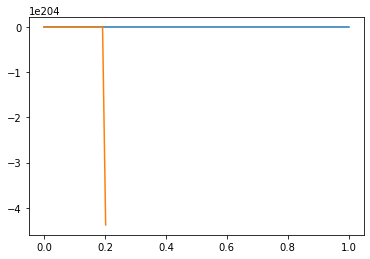

In [64]:
plt.plot(t_array, x_peloton(t_array))
plt.plot(t_array, x_b)

In [17]:
# stiff solver
#first we get the achievable power


0.7556563366087176